# Deskripsi tugas

Perusahaan taksi bernama Sweet Lift telah mengumpulkan data historis tentang pesanan taksi di bandara. Untuk menarik lebih banyak pengemudi pada jam sibuk, perlu memprediksi jumlah pesanan taksi untuk satu jam berikutnya. Projek ini akan membuat model untuk memprediksi pesanan tersebut. 

Metrik RMSE pada *test set* tidak boleh lebih dari 48.


## Deskripsi data

Data tersimpan di file `taxi.csv`. Jumlah pesanan di kolom'*num_orders*'.

## Persiapan

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('/datasets/taxi.csv')

In [3]:
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [4]:
df = pd.read_csv('/datasets/taxi.csv', parse_dates= [0], index_col = [0])

In [5]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [7]:
df.shape

(26496, 1)

In [8]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [9]:
df.sort_index(inplace= True)

In [10]:
df.isna().sum()

num_orders    0
dtype: int64

Data yang terdapat dalam fail awal sudah sesuai dengan yang diperlukan untuk pelaksanaan projek. 

## Analisis

Pada tahapan ini akan dilaksanakan analisis pola data seperti tren, musiman, dan residu data. 

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

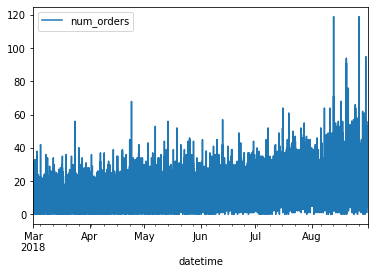

In [12]:
df.plot()
plt.show()

Berdasarkan ploting data mentah, distribusinya belum terlihat jelas. Oleh sebab itu, data perlu diambil rata-rata resampling. Akan digunakan resampling perhari untuk melihat pola yang lebih halus. 

In [13]:
df_day = df.resample('1D').mean()

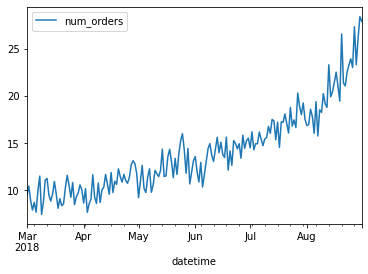

In [14]:
df_day.plot()
plt.show()

In [15]:
df_day['rolling_mean'] = df_day.rolling(7).mean()

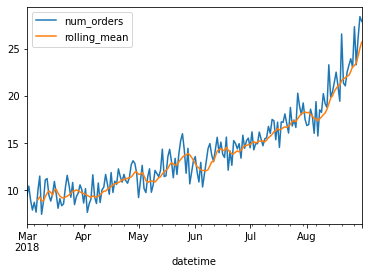

In [16]:
df_day.plot()
plt.show()

Hasil resampling dan perataan bergerak menunjukkan perubahan non-stasioner yang memiliki tren dan musiman. Pada tahapan berikutnya akan dianalisis pola tren dan musiman dari data. 

In [17]:
decomposed = seasonal_decompose(df.resample('1D').sum())

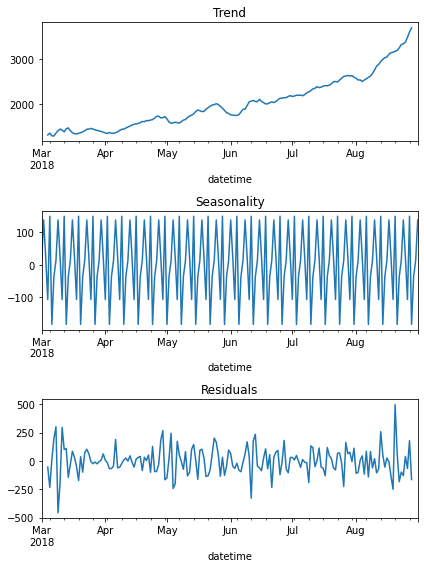

In [18]:
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax= plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax= plt.gca())
plt.title('Residuals')
plt.tight_layout()

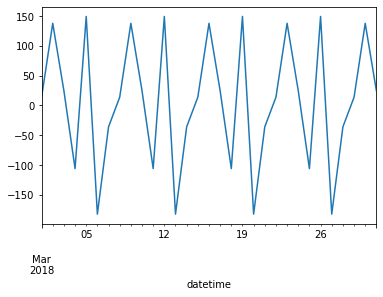

In [19]:
decomposed.seasonal['2018-03-01':'2018-03-31'].plot()
plt.show()

Berdasarkan plotting tren, musiman, dan residual data yang telah di resample, terlihat bahwa terdapat tren peningkatan jumlah pesanan setiap bulanya dan terdapat pola fluktuasi yang teratur setiap bulanya. Setelah dilihat pola musiman selama satu bulan, disimpulkan bahwa jumlah pesanan tinggi selama hari kerja dan menurun selama akhir minggu. 

## Pelatihan

Pada tahapan ini akan dilatih model untuk memprediksi jumlah pesanan satu jam kedepan. Model yang akan dilatih adalah regresi linear. Fitur-fitur yang akan digunakan sebagai pelatihan akan menggunakan data pesanan satu jam sebelumnya. Metrik yang akan digunakan sebagai evaluasi model adalah Mean Absolute Error dan Root Mean Squared Error. 

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [21]:
def eval_regression(X, y):
    mae = mean_absolute_error(X, y)
    rmse = mean_absolute_error(X, y)**0.5
    print('Metriks MAE dari model adalah: ', mae)
    print('Metriks RMSE dari model adalah: ', rmse)

In [22]:
df_model = df.resample('1H').sum()

In [23]:
df_model.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [24]:
train, test = train_test_split(df_model, shuffle= False, test_size = 0.2)

In [25]:
train.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [26]:
test.head()

,num_orders
datetime,
2018-07-26 04:00:00,131
2018-07-26 05:00:00,83
2018-07-26 06:00:00,21
2018-07-26 07:00:00,39
2018-07-26 08:00:00,80


In [27]:
test.shape

(884, 1)

In [28]:
train.shape

(3532, 1)

In [29]:
pred_median = np.ones(test.shape) * train['num_orders'].median()

In [30]:
eval_regression(test['num_orders'], pred_median)

Metriks MAE dari model adalah:  59.43778280542986
Metriks RMSE dari model adalah:  7.709590313721597


Projek menggunakan median dari data sebagai baseline awalan. Menggunakan median, kita memeroleh evaluasi MAE 59 dan RMSE 7.71. Hasil ini tentunya tidak sesuai dengan standar yang diinginkan oleh projek. Akan kita latih data dengan membuat fitur terlebih dahulu dan memilih parameter lag dan rolling average melalui parameter tuning program pembuatan fitur.

### Pembuatan Fitur

In [31]:
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

In [32]:
def fitur(data, max_lag, ma):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    for lag in range (1, max_lag+1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    data['moving_average'] = data['num_orders'].shift().rolling(ma).mean()
    return data

In [33]:
def parameter_tune(data):
    lr = LinearRegression()
    rmse_list = []
    best_rmse = float('inf')
    best_lag = None
    best_window = None
    for lg in range (3, 5):
        for m in range (3, 7):
            data = fitur(data.copy(), lg, m)
            train, test = train_test_split(data, test_size= 0.1, shuffle= False)
            train.dropna(inplace= True)
            X_train = train.drop('num_orders', axis= 1)
            y_train = train['num_orders']
            lr.fit(X_train, y_train)
            lr_train = lr.predict(X_train)
            rmse = mean_squared_error(y_train, lr_train)**0.5
            if rmse < best_rmse:
                best_rmse = rmse
                best_lag = lg
                best_window = m
    return best_rmse, best_lag, best_window

In [34]:
parameter_tune(df_model)

(30.502599214393747, 4, 6)

Berdasarkan pemilihan maximum lag dan jendela untuk rata-rata bergerak, ditemukan bahwa lag terbaik adalah 4 dan jendela terbaik adalah 6. Fitur dan target data train dan test akan dibuat menggunakan program fitur dengan parameter tersebut. 

## Pengujian

In [35]:
df_main = fitur(df_model, 4, 6)

In [36]:
df_main

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,moving_average
datetime,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,124.0,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,85.0,124.0,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,71.0,85.0,124.0,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,3,66.0,71.0,85.0,124.0,NaN
...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,2018,8,31,4,207.0,217.0,197.0,116.0,172.666667
2018-08-31 20:00:00,154,2018,8,31,4,136.0,207.0,217.0,197.0,167.666667
2018-08-31 21:00:00,159,2018,8,31,4,154.0,136.0,207.0,217.0,171.166667


In [37]:
train, test = train_test_split(df_main, test_size= 0.1, shuffle = False)

In [38]:
train.dropna(inplace = True)

In [39]:
X_train = train.drop('num_orders', axis= 1)
X_test = test.drop('num_orders', axis= 1)
y_train = train['num_orders']
y_test = test['num_orders']

In [40]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_train = lr.predict(X_train)
lr_test = lr.predict(X_test)
eval_regression(y_train , lr_train)
print()
eval_regression(y_test, lr_test)

Metriks MAE dari model adalah:  23.49709323273096
Metriks RMSE dari model adalah:  4.847380037992788

Metriks MAE dari model adalah:  40.338919415851294
Metriks RMSE dari model adalah:  6.351292735802003


Hasil metriks dari pelatihan model linear regresi memiliki error yang lebih rendah dibandingkan model baseline menggunakan prediksi median dan sudah sesuai dengan standar projek. Nilai MAE dan RMSE dari training set adalah 23,5 dan 4.85, sedangkan metriks MAE dan RMSE menggunakan test set adalah 40,3 dan 6,35. 

## Kesimpulan Umum

Projek ini bertujuan untuk memprediksi jumlah pesanan perusahan taksi selama satu jam kedepan. Berdasarkan data awal, terlihat bahwa terdapat tren meningkat pesanan perusahaan dari bulan ke bulan selama 6 bulan dengan musiman mingguan yang teratur. Model kemudian  perlu dilatih dengan mempertimbangkan tren ini. Berdasarkan prediksi hanya dengan median, terlihat bahwa metrik error nya memiliki nilai yang relatif besar. Akan tetapi dengan menggunakan model regresi linear yang dilatih menggunakan fitur yang diperoleh dengan data lag dan rataan bergerak berhasil menurunkan metrik error prediksi. 